>### 🚩 *Create a free WhyLabs account to get more value out of whylogs!*<br> 
>*Did you know you can store, visualize, and monitor whylogs profiles with the [WhyLabs Observability Platform](https://whylabs.ai/whylogs-free-signup?utm_source=whylogs-Github&utm_medium=whylogs-example&utm_campaign=Dask_Profiling)? Sign up for a [free WhyLabs account](https://whylabs.ai/whylogs-free-signup?utm_source=whylogs-Github&utm_medium=whylogs-example&utm_campaign=Dask_Profiling) to leverage the power of whylogs and WhyLabs together!*

# Dask Profiling
[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/whylabs/whylogs/blob/mainline/python/examples/integrations/Dask_Profiling.ipynb)


Hi! If you have a Dask available on your processing and modeling environment, you can leverage its delayed API to profile data with `whylogs` in a distributed way, and this is what we are going to cover in this example notebook 😃 

In [1]:
# Note: you may need to restart the kernel to use updated packages.
%pip install dask 'whylogs[viz]'

Note: you may need to restart the kernel to use updated packages.


In [2]:
from glob import glob
from typing import List
from functools import reduce

import dask
import pandas as pd
import whylogs as why
from whylogs.core import DatasetProfileView

## Read data
We will use a functional programming approach to read the data and profile it in parallel and then merge them back to a single profile, that can be further used to investigate important information, such as with a Constraints validation, a drift report, and much more. First, we will use the pandas library to read parquet files, assuming you have a directory with some parquet files available.

In [3]:
@dask.delayed
def read_data(parquet_file):
    df = pd.read_parquet(parquet_file)
    return df

## Profile data

The with pandas DataFrames in place, it is straight forward to profile your data with whylogs. To do so, let's also define a delayed function.

In [4]:
@dask.delayed
def log_data(df: pd.DataFrame):
    return why.log(df).view()

## Merge profiles

The last step in the pipeline is to merge the profiles we have created in the previous delayed steps, where we will take in a list of `DatasetProfileView` objects and turn them into a single profile that will contain the summary of relevant metrics that represent our data. 

In [5]:
def reduce_list(profile_list: List[DatasetProfileView]):
    result = reduce(lambda x, y: x.merge(y), profile_list)
    return result

In [6]:
data_list = [f"https://whylabs-public.s3.us-west-2.amazonaws.com/whylogs_examples/dask_example/example_{number}.parquet" for number in range(5)]

## Chaining execution

Now we will chain together the logic of our code execution, by creating the output list with the profiles from the read data. With it, we can create a Dask delayed task, and this will make sure to create our task graph properly.

In [7]:
output = []

for file in data_list:
    df = read_data(parquet_file=file)
    profile_view = log_data(df=df)
    output.append(profile_view)

task = dask.delayed(reduce_list)(output)

## Visualizing the execution plan

To view what the task graph looks like, we need the `graphviz` library available. Then we can call Dask's visualize method and check what are the planned steps for our computations.

In [8]:
%pip install -q graphviz

Note: you may need to restart the kernel to use updated packages.


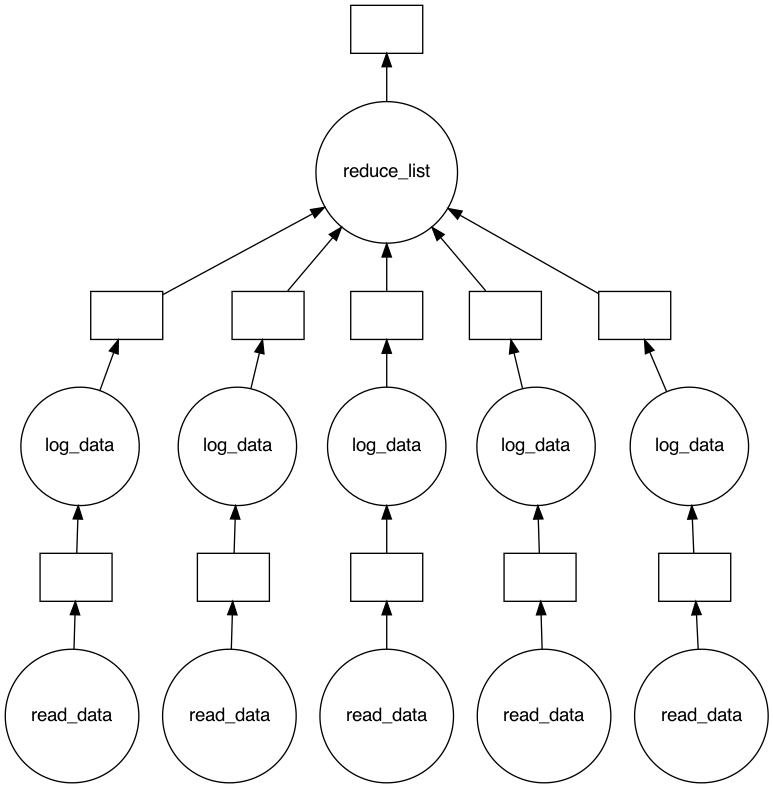

In [9]:
task.visualize()

## Triggering execution

Up until now, we only have planned what to execute using the delayed decorator in our simple processes. When we want to trigger the execution, we need to call the action, and that can be done with the compute method. This will return us a single merged `DatasetProfileView` object. 

In [10]:
merged_profile_view = task.compute()

And now we can investigate important metric in our entire dataset! Let's use whylogs' extra visualization package to see some metrics from our data.

In [11]:
from whylogs.viz import NotebookProfileVisualizer

visualization = NotebookProfileVisualizer()
visualization.set_profiles(target_profile_view=merged_profile_view)

visualization.profile_summary()

And that's it, you have successfully created a DatasetProfileView with whylogs in a distributed manner with Dask! 😄
If you wish to have other insights on how to use whylogs, feel free to check our [other existing examples](https://github.com/whylabs/whylogs/tree/mainline/python/examples), as they might be extremely useful. Happy coding!